# Detrending and De-seasonalization
[Detrending](#detrending)

[Atomic detrending](#atom_detrend)

[Fit linear model](#lm)

[De-seasonalization](#season)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pymongo
from pprint import pprint
from datetime import datetime, timedelta, date
import pandas as pd

import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True) # for live plot
pd.set_option('display.notebook_repr_html', False)
%matplotlib inline
plt.style.use('seaborn-white')

In [3]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)
pprint(mg.database_names())

['ECMWF', 'local']


In [4]:
db = mg.ECMWF
db.collection_names()

['ERAINT_grid',
 'ERAINT_lores_grid',
 'ERAINT_lores_monthly',
 'ERAINT_monthly',
 'system.indexes']

In [5]:
ERA_vers = 'lores'

if (ERA_vers == 'hires'):
    col_dat = 'ERAINT_monthly'
    col_grid = 'ERAINT_grid'
    resolution = 0.25
elif (ERA_vers == 'lores'):
    col_dat = 'ERAINT_lores_monthly'
    col_grid = 'ERAINT_lores_grid'
    resolution = 2.5

## Detrending <a id='detrending'></a>

In [6]:
con_data = db[col_dat]

In [7]:
fo = con_data.find_one()
pprint(fo)

{'_id': ObjectId('5a1af5c28cb6b8333ed30d63'),
 'al': 0.07,
 'blh': 133.39,
 'ci': 1.0,
 'd2m': 239.53,
 'date': datetime.datetime(1979, 1, 1, 0, 0),
 'hcc': 0.2,
 'id_grid': 1,
 'ie': 0.0,
 'ishf': 11.48,
 'istl1': 242.55,
 'lcc': 0.51,
 'mcc': 0.15,
 'msl': 102793.31,
 'si10': 5.65,
 'skt': 242.63,
 'sp': 102792.57,
 'sst': 271.46,
 'stl1': 242.63,
 't2m': 242.7,
 'u10': 0.95,
 'v10': 0.28,
 'year': 1979,
 'z70': 169747.63}


In [8]:
this_id_grid = 777
qry = {"id_grid": this_id_grid}
res = con_data.find(filter=qry, projection={"_id": 0})
res.count()

464

In [9]:
df = pd.DataFrame(list(res))
df.head()

     al     blh       ci     d2m       date   hcc  id_grid   ie   ishf  \
0  0.47  244.66 -32767.0  260.38 2017-08-01  0.29      777  0.0  10.57   
1  0.47  165.98 -32767.0  261.69 2017-07-01  0.19      777 -0.0   9.21   
2  0.47  238.26 -32767.0  260.17 2017-06-01  0.15      777 -0.0   4.88   
3  0.48  224.00 -32767.0  254.53 2017-05-01  0.13      777 -0.0  13.24   
4  0.48   67.72 -32767.0  237.47 2017-04-01  0.12      777  0.0  21.34   

    istl1    ...      si10     skt        sp      sst    stl1     t2m   u10  \
0  271.46    ...      6.24  261.20  73935.30 -32767.0  252.83  262.59  5.06   
1  271.46    ...      5.52  263.15  74037.73 -32767.0  251.09  264.48  3.14   
2  271.46    ...      5.37  262.04  74043.33 -32767.0  248.72  262.90  3.07   
3  271.46    ...      6.34  256.32  74209.79 -32767.0  244.77  257.66  4.49   
4  271.46    ...      6.17  238.79  73157.42 -32767.0  239.33  241.04  4.78   

    v10  year        z70  
0  0.15  2017  182650.25  
1  1.42  2017  183701.39  

In [10]:
# Create a new column with the month index
df2 = df.assign(month=list(map(lambda x: x.month, df.date)))
df2.head()

     al     blh       ci     d2m       date   hcc  id_grid   ie   ishf  \
0  0.47  244.66 -32767.0  260.38 2017-08-01  0.29      777  0.0  10.57   
1  0.47  165.98 -32767.0  261.69 2017-07-01  0.19      777 -0.0   9.21   
2  0.47  238.26 -32767.0  260.17 2017-06-01  0.15      777 -0.0   4.88   
3  0.48  224.00 -32767.0  254.53 2017-05-01  0.13      777 -0.0  13.24   
4  0.48   67.72 -32767.0  237.47 2017-04-01  0.12      777  0.0  21.34   

    istl1  ...       skt        sp      sst    stl1     t2m   u10   v10  year  \
0  271.46  ...    261.20  73935.30 -32767.0  252.83  262.59  5.06  0.15  2017   
1  271.46  ...    263.15  74037.73 -32767.0  251.09  264.48  3.14  1.42  2017   
2  271.46  ...    262.04  74043.33 -32767.0  248.72  262.90  3.07  1.88  2017   
3  271.46  ...    256.32  74209.79 -32767.0  244.77  257.66  4.49  2.35  2017   
4  271.46  ...    238.79  73157.42 -32767.0  239.33  241.04  4.78  1.59  2017   

         z70  month  
0  182650.25      8  
1  183701.39      7  
2 

In [11]:
# groupby test:
df3 = df2.groupby('month').mean()
df3

         al         blh       ci         d2m       hcc  id_grid   ie  \
month                                                                  
1      0.48   74.816667 -32767.0  231.851538  0.250000    777.0  0.0   
2      0.48   69.109487 -32767.0  231.103333  0.219744    777.0  0.0   
3      0.48   70.546923 -32767.0  232.358974  0.174615    777.0  0.0   
4      0.48   97.546923 -32767.0  239.932051  0.133333    777.0  0.0   
5      0.48  169.516154 -32767.0  250.872308  0.123333    777.0  0.0   
6      0.47  229.896154 -32767.0  259.974103  0.163077    777.0  0.0   
7      0.47  193.235641 -32767.0  262.548205  0.180256    777.0  0.0   
8      0.47  129.668974 -32767.0  257.902821  0.208462    777.0  0.0   
9      0.48   74.311579 -32767.0  247.858947  0.220263    777.0  0.0   
10     0.48   60.989211 -32767.0  238.740263  0.202368    777.0  0.0   
11     0.48   69.552895 -32767.0  234.856842  0.235789    777.0  0.0   
12     0.48   68.697632 -32767.0  232.621842  0.255526    777.0 

### Atomic detrending <a id=atom_detrend></a>
* Extract anomaly with regard to long-term trend
* Because the de-trending is done for each month, it also serves as de-seasonaization

In [15]:
# Atomic detrending
ts = df2[['date', 'month', 'z70']].query('month == 1').sort_values('date').reset_index(drop=True)
ts.head() # rem: we are working with monthly values

        date  month        z70
0 1979-01-01      1  170285.77
1 1980-01-01      1  170686.70
2 1981-01-01      1  167045.80
3 1982-01-01      1  170311.73
4 1983-01-01      1  166269.08

In [18]:
# Plot ts
data = [go.Scatter(x=ts['date'], y=ts['z70'] )]
py.iplot(data, filename='pandas-time-series')

### Fit linear regression <a id='lm'></a>

In [43]:
import sklearn.linear_model as skl_lm
model = skl_lm.LinearRegression()
this_variable = 'z70'
# Covariate is the number of days since the beg. of TS
X = (ts.date -  ts.date[0]).dt.days.values.reshape(-1, 1)
y = ts[[this_variable]]
model.fit(X, y)
lm_pred = model.predict(X)

In [44]:
ts2 = ts.assign(fit = lm_pred)
ts2 = ts2.assign(resid = ts2.fit-ts2[this_variable])
ts2.head()

        date  month        z70            fit        resid
0 1979-01-01      1  170285.77  168721.135478 -1564.634522
1 1980-01-01      1  170686.70  168777.287565 -1909.412435
2 1981-01-01      1  167045.80  168833.593493  1787.793493
3 1982-01-01      1  170311.73  168889.745580 -1421.984420
4 1983-01-01      1  166269.08  168945.897667  2676.817667

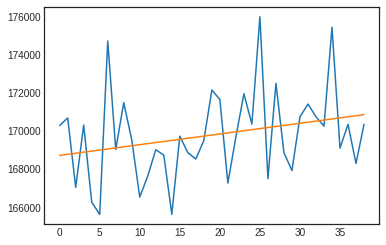

In [45]:
# plot trend
plt.plot(ts2[[this_variable]])
plt.plot(ts2[['fit']])
plt.show()

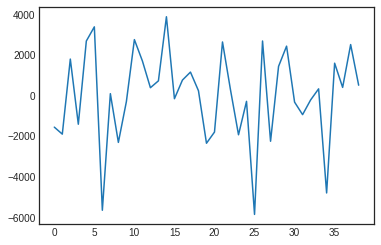

In [42]:
# plot detrended ts
plt.plot(ts2.resid)
plt.show()

## De-seasonalization <a id=season></a>
Actually not useful since the seasonality has been removed in the monthly de-trending

In [54]:
this_id_grid = 777
this_variable = 'z70'
pip = [ {"$project": {"id_grid": 1, "date": 1, this_variable: 1, "month": {"$month": "$date"}}},
        {"$match": {"month": {"$in": [9, 10, 11, 12, 1, 2]},
                              "id_grid": {"$in": [this_id_grid]} }},
        {"$project": {"_id": 0, "id_grid": 1, "date": 1, this_variable: 1}} ]
res = con_data.aggregate(pipeline = pip)

In [55]:
df = pd.DataFrame(list(res))
df.head()

        date  id_grid        z70
0 1979-01-01      777  170285.77
1 1979-02-01      777  171493.91
2 1979-09-01      777  179985.50
3 1979-10-01      777  177038.08
4 1979-11-01      777  174233.24